# Can we detect climate misinformation by analysing a single word or phrase?

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import sys

pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:.2%}'.format

sys.path.insert(0, '../text_preprocessing/')

In [2]:
from preprocessing import *
from embeddings import *

/usr/local/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
path = '../labelled_data/labelled_data_14032021.csv'

print("Importing data...")
df = import_data(path)

print("\nDropping na values..")
df = na_values(df)

print("\nEncoding classes..")
df, label_columns = class_encoding(df)

# print("\nFiltering long doocuments and exploring length..")
# documents_len_exploration_and_filter(df,max_len=1500)

print("\nStarting text preprocessing..")
clean_text = preprocessing(df)

df['clean_text'] = clean_text

print(len(df))
df.head()

../text_preprocessing/preprocessing.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded['human_label'] = encoded_classes
../text_preprocessing/preprocessing.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded['human_binary_label'] = df_encoded['human_label'].apply(lambda label: 1 if label > 0 else 0)


Importing data...
   label                                               text
0    118  Buenos Aires Playa is an urban beach on the Rí...
1    123  Contributed by Robert Lyman  © 2017The United ...
2    119  Contributed by Robert Lyman  © 2017The United ...
3    119  Share this...FacebookTwitterState parliamentar...
4    122  [CHECK OUT OUR PLANS](https://thebfd.co.nz/sub...
Size of dataframe
Index(['label', 'text'], dtype='object')
(778, 2)

Dropping na values..
NaN values per column
label     0
text     62
dtype: int64

Encoding classes..
118 is encoded to [0]
119 is encoded to [1]
120 is encoded to [2]

Starting text preprocessing..
628


,text,human_label,human_binary_label,clean_text
0,Buenos Aires Playa is an urban beach on the Rí...,0,0,"[buenos, aire, playa, urban, beach, ro, de, la..."
2,Contributed by Robert Lyman © 2017The United ...,1,1,"[contribute, robert, lyman, unite, kingdom, fi..."
3,Share this...FacebookTwitterState parliamentar...,1,1,"[thisfacebooktwitterstate, parliamentarian, wo..."
5,"On April 7, I wrote about global warming “hoth...",0,0,"[april, write, global, warm, hothead, dominate..."
6,From PragerU\r\nHas environmentalism become mo...,2,1,"[prageru, environmentalism, become, good, fait..."


## Wordclouds for each Class

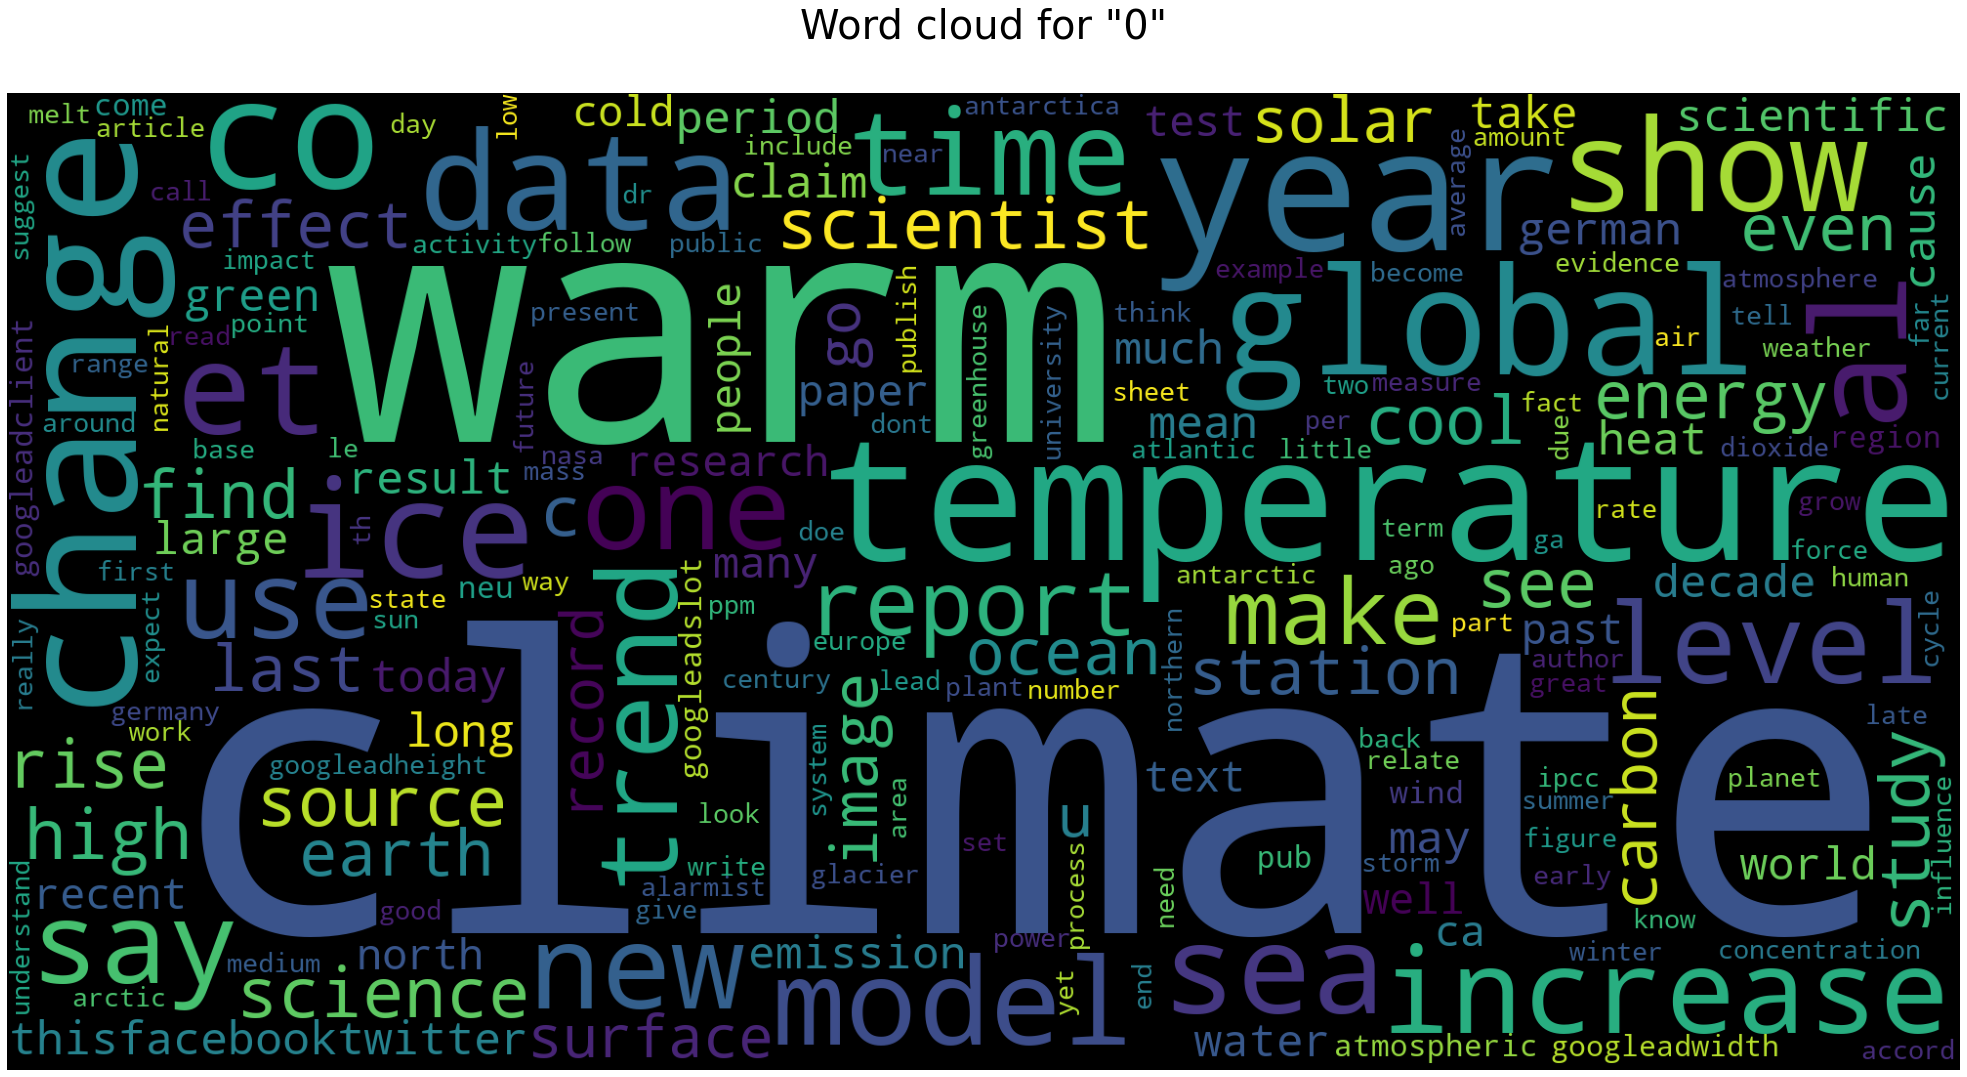



#########




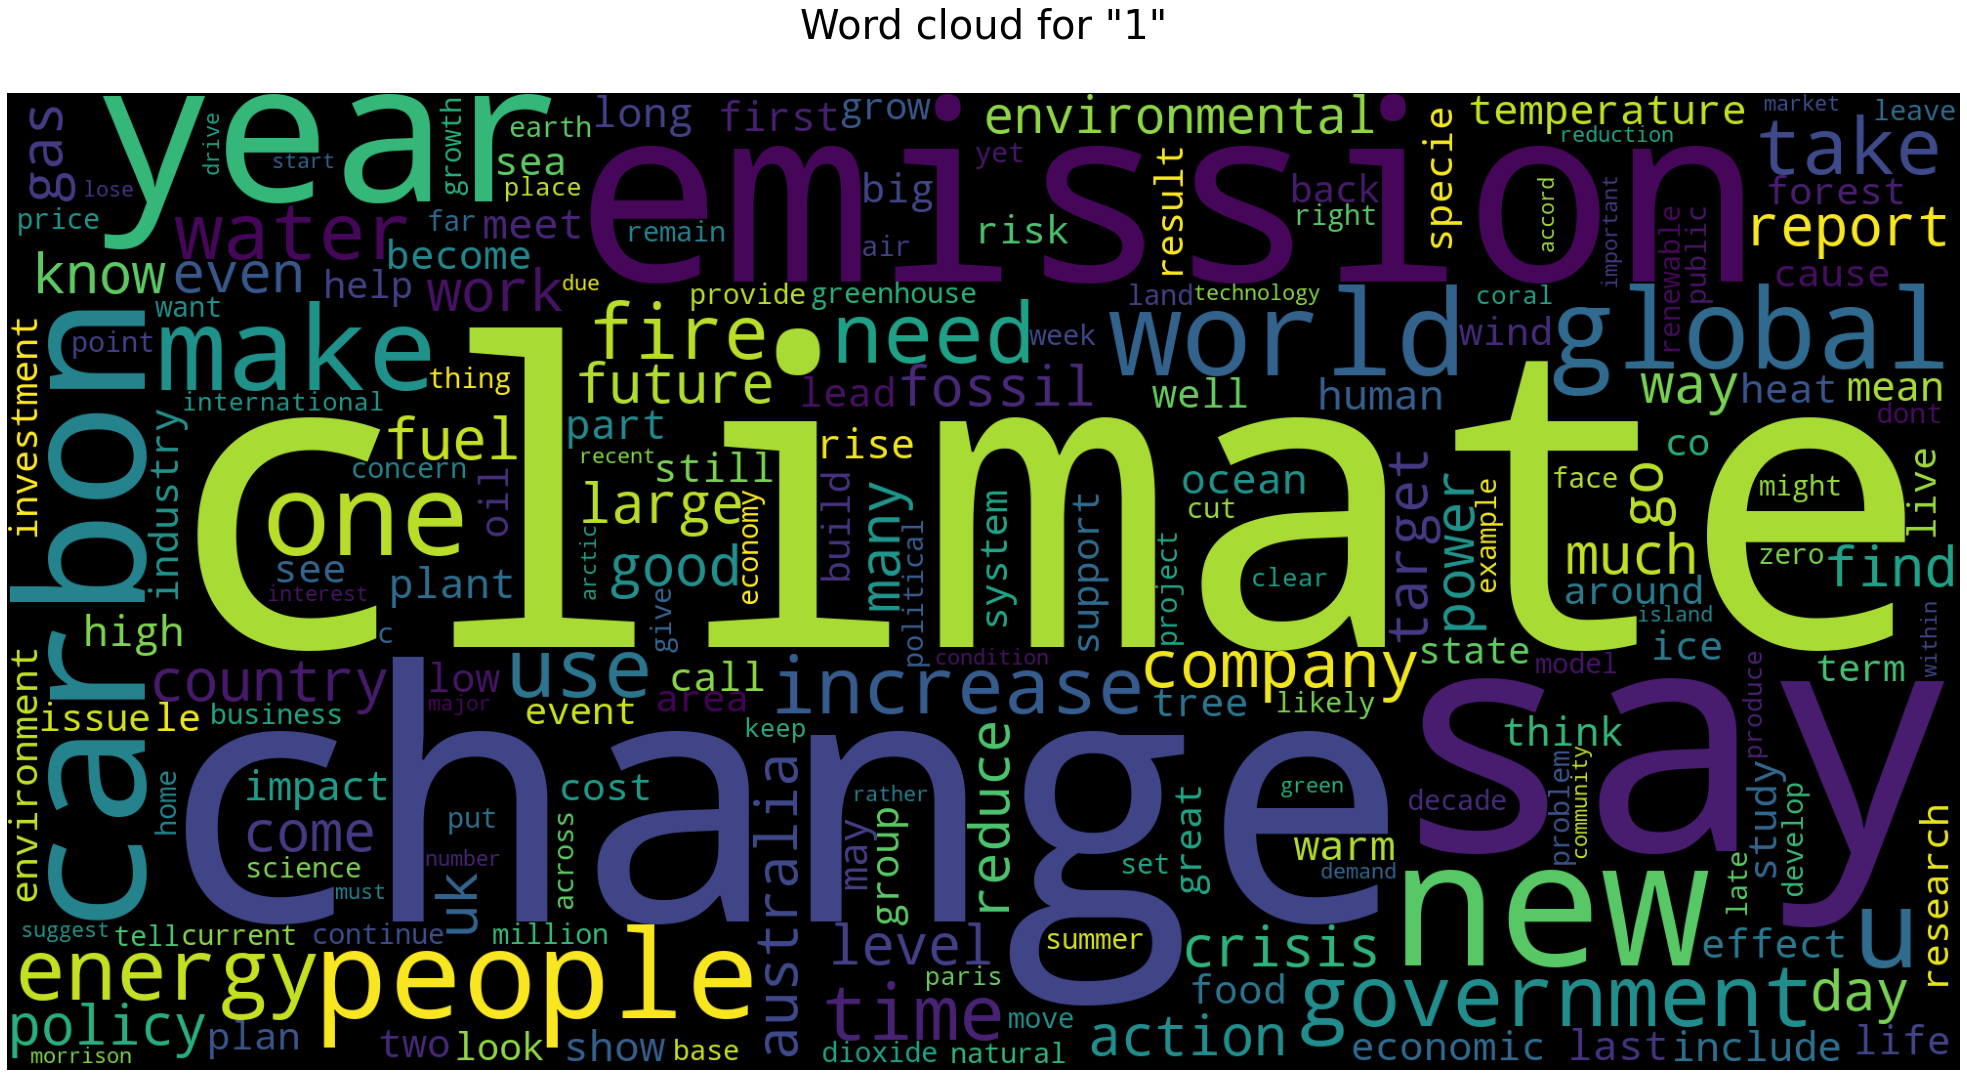



#########




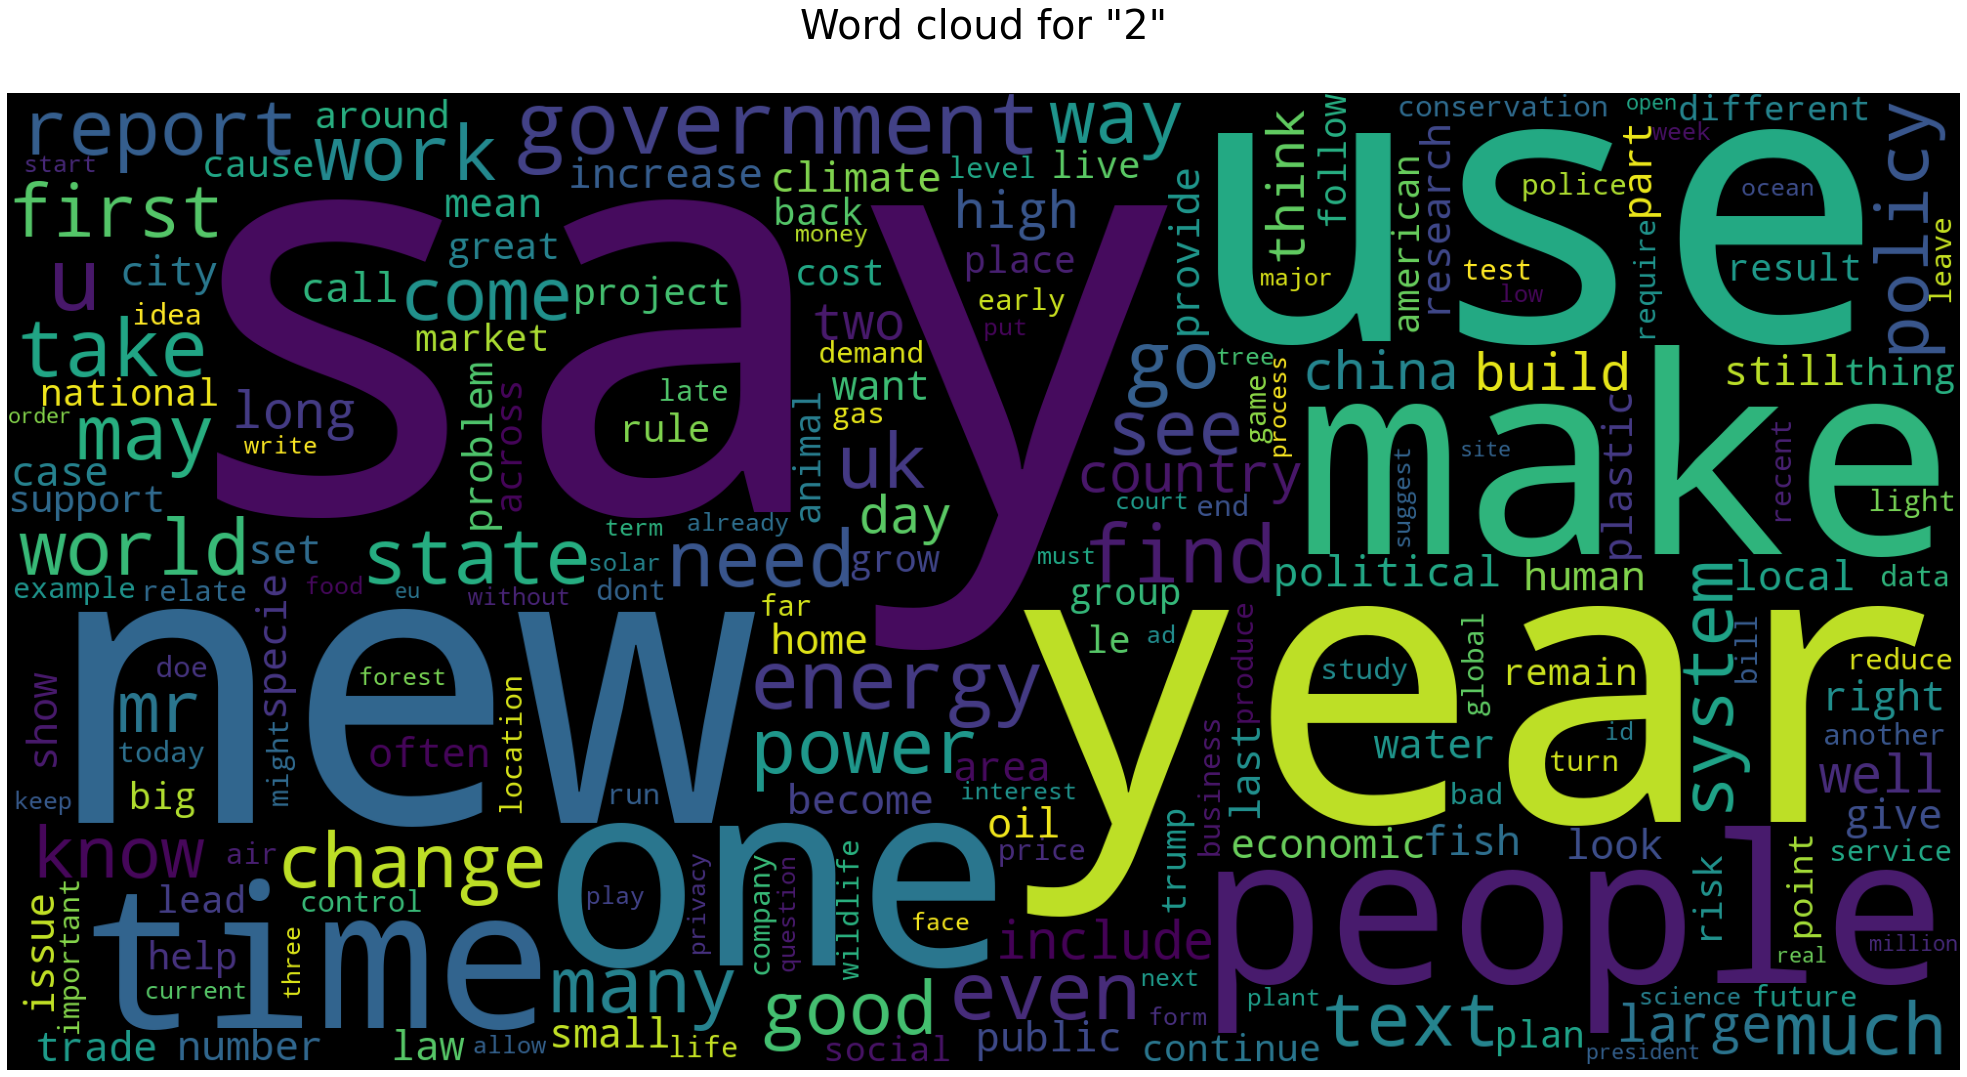



#########




In [4]:
def plot_wordcloud(label):

    plt.figure(figsize=(35,20))

    full_text = ""
    for doc in df[df.human_label == label].clean_text.to_list():
        for text in doc:
            full_text = "{0} {1}".format(full_text,text).strip()
    
    cloud_text = WordCloud(
                              stopwords=STOPWORDS,
                              background_color='black',
                              collocations=False,
                              width=2000,
                              height=1000
                             ).generate(full_text)
    plt.axis('off')
    plt.title('Word cloud for "{0}"\n'.format(label),fontsize=40)
    plt.imshow(cloud_text)
    plt.show()

for col in df.human_label.unique():
    plot_wordcloud(col)
    print("\n\n#########\n\n")

## Most frequent Keywords

In [5]:
top_n = []
n = 500

for col in df.human_label.unique():
    print(col)
    words = []
    for doc in df.loc[df.human_label == col, 'clean_text'].to_list():
        words += doc

    d = {
        "label": col,
        "top_{0}".format(n): pd.Series(words).value_counts()[:n].index
    }
    top_n.append(d)

top_n

0
1
2


[{'label': 0,
  'top_500': Index(['climate', 'warm', 'temperature', 'year', 'change', 'co', 'global',
         'data', 'ice', 'al',
         ...
         'keep', 'sensor', 'money', 'review', 'center', 'therefore', 'warn',
         'climategate', 'mountain', 'stream'],
        dtype='object', length=500)},
 {'label': 1,
  'top_500': Index(['climate', 'change', 'say', 'emission', 'year', 'carbon', 'people',
         'new', 'world', 'would',
         ...
         'capacity', 'along', 'near', 'material', 'course', 'hour', 'africa',
         'strike', 'beyond', 'test'],
        dtype='object', length=500)},
 {'label': 2,
  'top_500': Index(['say', 'would', 'year', 'use', 'make', 'one', 'people', 'new', 'also',
         'time',
         ...
         'store', 'foreign', 'official', 'care', 'damage', 'paper', 'solution',
         'full', 'five', 'bee'],
        dtype='object', length=500)}]

In [6]:
analysed_words = []

def word_analysis(word_list, min_length=4, min_freq=0.0, max_freq_other=1.0):

    data_list = []
    for word in sorted(word_list):
        if len(word) < min_length:
            continue

        mask = df.clean_text.apply(lambda x: word in x)
        freq = df.loc[mask, "human_label"].value_counts() / df.human_label.value_counts()
        if (freq[0] < min_freq) or (freq[1] > max_freq_other) and (freq[2] > max_freq_other):
            continue

        print("\n\n##### {0}\n".format(word))
        print(freq)
        data = pd.DataFrame(freq).T
        data["word"] = word
        data_list.append(data)

    print("\n\n##### {0} words selected for analysis".format(len(data_list)))
        
    return data_list

analysed_words += word_analysis(top_n[0]["top_{0}".format(n)], min_freq=0.3, max_freq_other=0.3)



##### accord

0   33.20%
2   20.81%
1   27.61%
Name: human_label, dtype: float64


##### claim

0   34.43%
2   13.12%
1   17.18%
Name: human_label, dtype: float64


##### climate

0   80.33%
1   86.50%
2   26.24%
Name: human_label, dtype: float64


##### data

0   37.30%
2   17.65%
1   23.31%
Name: human_label, dtype: float64


##### decade

0   30.33%
1   32.52%
2   16.74%
Name: human_label, dtype: float64


##### fact

0   31.56%
2   22.17%
1   23.31%
Name: human_label, dtype: float64


##### global

0   54.92%
1   63.19%
2   20.81%
Name: human_label, dtype: float64


##### googleadclient

0   51.64%
2    5.43%
1    4.91%
Name: human_label, dtype: float64


##### googleadheight

0   51.64%
2    5.43%
1    4.91%
Name: human_label, dtype: float64


##### googleadslot

0   51.64%
2    5.43%
1    4.91%
Name: human_label, dtype: float64


##### googleadwidth

0   51.64%
2    5.43%
1    4.91%
Name: human_label, dtype: float64


##### image

0   32.38%
2    9.95%
1    6.13%
Name: human_la

## Most frequent Keywords (misinfo focus)

In [7]:
top_misinfo_only = []

for val in top_n[0]["top_{0}".format(n)]:
    if (val in top_n[1]["top_{0}".format(n)]) or (val in top_n[2]["top_{0}".format(n)]):
        continue
    top_misinfo_only.append(val)

print("{0} of top 100 misinfo not in other top 100s".format(len(top_misinfo_only)))

analysed_words += word_analysis(top_misinfo_only, min_length=4, min_freq=0.3, max_freq_other=0.3)

140 of top 100 misinfo not in other top 100s


##### googleadclient

0   51.64%
2    5.43%
1    4.91%
Name: human_label, dtype: float64


##### googleadheight

0   51.64%
2    5.43%
1    4.91%
Name: human_label, dtype: float64


##### googleadslot

0   51.64%
2    5.43%
1    4.91%
Name: human_label, dtype: float64


##### googleadwidth

0   51.64%
2    5.43%
1    4.91%
Name: human_label, dtype: float64


##### thisfacebooktwitter

0   66.39%
2    7.69%
1    6.13%
Name: human_label, dtype: float64


##### trend

0   34.84%
1   10.43%
2    6.33%
Name: human_label, dtype: float64


##### 6 words selected for analysis


## Curated Keywords from Notion

In [8]:
notion_words_misinfo = ["climatecult", "climatehysteria", "globalcooling", "climatescam", "climatehoax", "climatechangehoax",
                        "greenwashing"]

notion_words_climate = ["TheTimeIsNow", "weneedexperts", "ecology", "climatechange", "HowtoSavethePlanet", "VoiceForThePlanet",
                        "FightForYourWorld", "connect2earth", "globalwarming"]

notion_words_notrel = ["coronavirus"]

notion_keywords = [
    {"label": "Climate Misinformation", "words": notion_words_misinfo},
    {"label": "Climate Related", "words": notion_words_climate},
    {"label": "Not Climate Related", "words": notion_words_notrel},
]

for k in notion_keywords:
    print("\n-------------------------------\n{0}\n{1}".format(k["label"], k["words"]))
    analysed_words += word_analysis(k["words"])


-------------------------------
Climate Misinformation
['climatecult', 'climatehysteria', 'globalcooling', 'climatescam', 'climatehoax', 'climatechangehoax', 'greenwashing']


##### climatechangehoax

0   NaN
2   NaN
1   NaN
Name: human_label, dtype: float64


##### climatecult

0   NaN
2   NaN
1   NaN
Name: human_label, dtype: float64


##### climatehoax

0   NaN
2   NaN
1   NaN
Name: human_label, dtype: float64


##### climatehysteria

0   NaN
2   NaN
1   NaN
Name: human_label, dtype: float64


##### climatescam

0   NaN
2   NaN
1   NaN
Name: human_label, dtype: float64


##### globalcooling

0   NaN
2   NaN
1   NaN
Name: human_label, dtype: float64


##### greenwashing

0     NaN
1   1.23%
2     NaN
Name: human_label, dtype: float64


##### 7 words selected for analysis

-------------------------------
Climate Related
['TheTimeIsNow', 'weneedexperts', 'ecology', 'climatechange', 'HowtoSavethePlanet', 'VoiceForThePlanet', 'FightForYourWorld', 'connect2earth', 'globalwarming']


####

## Summary

In [9]:
summary = pd.concat(analysed_words, ignore_index=True)
print(summary.columns)
summary.drop_duplicates(inplace=True)
summary.columns = ["Climate denying", "Non climate", "Climate related", "Word"]
print(summary.columns)
summary.set_index("Word", inplace=True)
summary["Precision (misinfo)"] = summary["Climate denying"]
summary["Recall (misinfo)"] = (summary["Climate denying"] * df[df.human_label == 0].shape[0]) / (
                                    (summary["Climate denying"] * df[df.human_label == 0].shape[0])
                                    + (summary["Climate related"] * df[df.human_label == 1].shape[0])
                                    + (summary["Non climate"] * df[df.human_label == 2].shape[0])
                                )
summary["F1 (misinfo)"] = 2 * summary["Precision (misinfo)"] * summary["Recall (misinfo)"] / (
                                summary["Precision (misinfo)"] + summary["Recall (misinfo)"] 
                            )
summary.fillna(0, inplace=True)
summary.sort_values(by="F1 (misinfo)", ascending=False, inplace=True)

print("{0} words analysed".format(summary.shape[0]))
summary

Index([0, 2, 1, 'word'], dtype='object')
Index(['Climate denying', 'Non climate', 'Climate related', 'Word'], dtype='object')
40 words analysed


,Climate denying,Non climate,Climate related,Precision (misinfo),Recall (misinfo),F1 (misinfo)
Word,,,,,,
thisfacebooktwitter,66.39%,7.69%,6.13%,66.39%,85.71%,74.83%
googleadclient,51.64%,5.43%,4.91%,51.64%,86.30%,64.62%
googleadwidth,51.64%,5.43%,4.91%,51.64%,86.30%,64.62%
googleadheight,51.64%,5.43%,4.91%,51.64%,86.30%,64.62%
googleadslot,51.64%,5.43%,4.91%,51.64%,86.30%,64.62%
warm,61.48%,7.69%,34.36%,61.48%,67.26%,64.24%
climate,80.33%,26.24%,86.50%,80.33%,49.62%,61.35%
test,53.28%,20.81%,13.50%,53.28%,65.66%,58.82%
temperature,50.00%,8.14%,30.06%,50.00%,64.55%,56.35%
